# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: L2 regularization in practice
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [24]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np

In [25]:
# import dataset
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [26]:
data = torch.tensor(iris[iris.columns[0: 4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

train_dataDataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataDataset  = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

## model

In [36]:
def createModel(L2lambda):

    ANNiris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    lossFn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.005, weight_decay=L2lambda)

    return ANNiris, lossFn, optimizer

## Train

In [39]:
EPOCHS = 1000

def trainModel(epochs = 1000):

    trainAcc = []
    testAcc = []
    losses = []

    for epoch in range(epochs):

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            _y = ANNiris(X)
            _loss = lossFn(_y, y)

            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()

            batchAcc.append(100 * torch.mean((torch.argmax(_y,axis=1) == y).float()).item() )
            batchLoss.append(_loss.item())

        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        ANNiris.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

        # no worries, reset here ;)
        ANNiris.train()

    # function output
    return trainAcc,testAcc,losses

            

In [40]:
# create a model
L2lambda = .01
ANNiris,lossFn,optimizer = createModel(L2lambda)

# train the model
trainAcc,testAcc,losses = trainModel()

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/yh/kw1cv88n6md03rt17nczlk240000gn/T/ipykernel_92350/573527260.py:9: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
/var/folders/yh/kw1cv88n6md03rt17nczlk240000gn/T/ipykernel_92350/573527260.py:13: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))


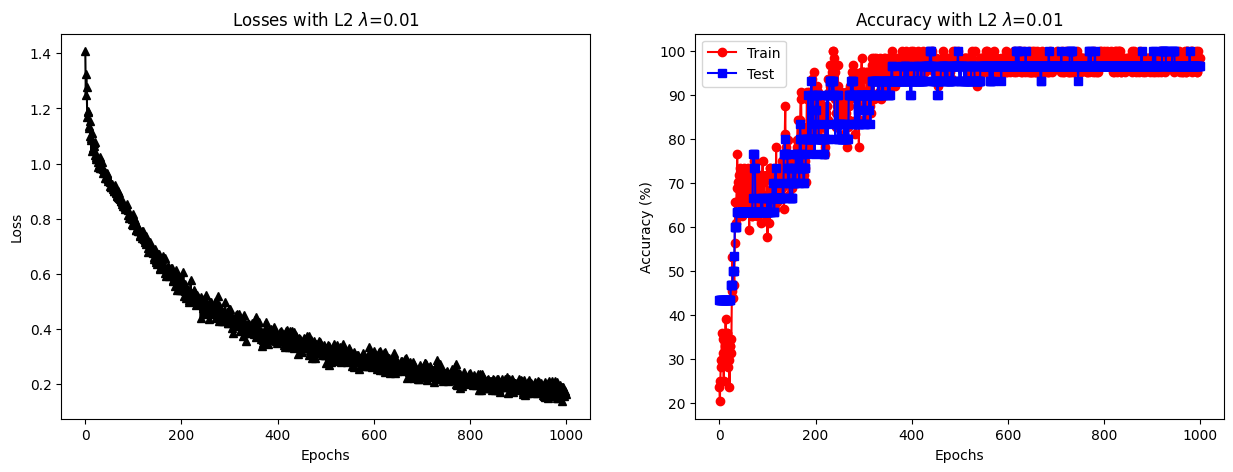

In [41]:
import matplotlib.pyplot as plt
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [42]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')